In [92]:
import math
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [42]:
fc_df = pd.read_csv('fc_vals.csv').drop('Unnamed: 0', axis=1).T
#a relative path is easier when collaborating

In [28]:
participants_df = pd.read_csv('participants.tsv', sep = '\t', 
                              index_col='participant_id')

In [29]:
participants_df.head()

,Age,AgeGroup,Child_Adult,Gender,Handedness,ToM Booklet-Matched,ToM Booklet-Matched-NOFB,FB_Composite,FB_Group,WPPSI BD raw,WPPSI BD scaled,KBIT_raw,KBIT_standard,DCCS Summary,Scanlog: Scanner,Scanlog: Coil,Scanlog: Voxel slize,Scanlog: Slice Gap
participant_id,,,,,,,,,,,,,,,,,,
sub-pixar001,4.774812,4yo,child,M,R,0.80,0.736842,6.0,pass,22.0,13.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1
sub-pixar002,4.856947,4yo,child,F,R,0.72,0.736842,4.0,inc,18.0,9.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.1
sub-pixar003,4.153320,4yo,child,F,R,0.44,0.421053,3.0,inc,15.0,9.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1
sub-pixar004,4.473648,4yo,child,F,R,0.64,0.736842,2.0,fail,17.0,10.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.2
sub-pixar005,4.837782,4yo,child,F,R,0.60,0.578947,4.0,inc,13.0,5.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.2


In [35]:
participants_df.loc[participants_df['Gender'] == 'M'] = 0
participants_df.loc[participants_df['Gender'] == 'F'] = 1

In [52]:
fc_df = fc_df.join(participants_df['Gender'])  

In [56]:
kfolds = KFold(
        n_splits=5,
        shuffle=True)

In [97]:
acc_scores = [] 
for fold_idx, (train_idx, test_idx) in enumerate( kfolds.split(X=fc_df) ):
    train_df = fc_df.iloc[train_idx, :]
    test_df = fc_df.iloc[test_idx, :]

    x_train = train_df.drop('Gender', axis=1)
    y_train = train_df['Gender'].astype(int)

    x_test = test_df.drop('Gender', axis=1) 
    y_test = test_df['Gender'].astype(int)
    
    scaler = StandardScaler()
    #scale seperately - MH needs to fix in her own code
    scaler.fit_transform(x_train)
    scaler.fit_transform(x_test)

    logistic_model = LogisticRegressionCV(penalty='l2') #C=1/Lambda
    logistic_model.fit(x_train, y_train)

    #coefficients
    coefficients = logistic_model.coef_
    print('Smallest coefficient', coefficients.min())
    print('Largest coefficient:', coefficients.max())

    #calc accuracy
    acc_scores.append(accuracy_score(logistic_model.predict(x_test), y_test))
print(acc_score) 

Smallest coefficient -0.06275258881685361
Largest coefficient: 0.07079592533250985
Smallest coefficient -0.7774163995085799
Largest coefficient: 0.6660466922879988
Smallest coefficient -0.8627539293443343
Largest coefficient: 1.2523482934459735
Smallest coefficient -0.012251692834347327
Largest coefficient: 0.012878757044052601
Smallest coefficient -0.2591663810197839
Largest coefficient: 0.22513333569989263
0.5789473684210527


In [27]:
# create a confusion matrix
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values 
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    heatmap = sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg']) 
    
    fig = heatmap.get_figure()
    fig.savefig("confusion_matrix.png")

from sklearn.metrics import confusion_matrix
tp = confusion_matrix(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:, :-1]))[1,1]
fp = confusion_matrix(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:, :-1]))[0,1]
tn = confusion_matrix(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:, :-1]))[0,0]
fn = confusion_matrix(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:, :-1]))[1,0]

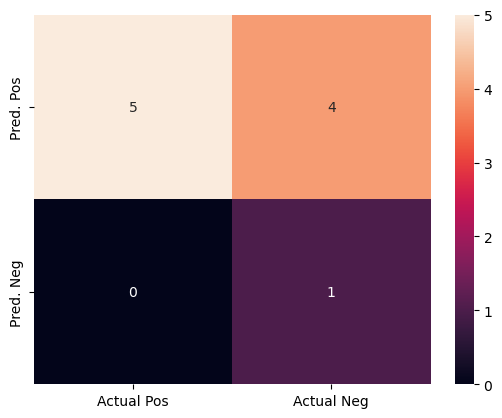

In [28]:
plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)

In [29]:
# set up different regularization penalties to try
l2_penalties = [0.01, 1, 4, 10, 1e2, 1e3, 1e5]
l2_penalty_names = [f'coefficients [L2={l2_penalty:.0e}]' 
                    for l2_penalty in l2_penalties]

coef_table = pd.DataFrame(columns=['features'] + l2_penalty_names)
coef_table['features'] = np.arange(10000)

accuracy_data = []

for l2_penalty, l2_penalty_column_name in zip(l2_penalties, l2_penalty_names):
     model = LogisticRegression(penalty='l2', C=1/l2_penalty, random_state=0, fit_intercept=False)
     model.fit(train_data.iloc[:,:-1], train_data['Gender'].astype(int))
     coef_table[l2_penalty_column_name] = model.coef_[0]

     train_accuracy = accuracy_score(train_data['Gender'].astype(int), model.predict(train_data.iloc[:,:-1]))
     validation_accuracy = accuracy_score(validation_data['Gender'].astype(int), model.predict(validation_data.iloc[:,:-1]))
     accuracy_data.append({'l2_penalty': l2_penalty, 'train_accuracy': train_accuracy, 'validation_accuracy':validation_accuracy})

accuracies_table = pd.DataFrame(accuracy_data)    

In [30]:
coef_table

,features,coefficients [L2=1e-02],coefficients [L2=1e+00],coefficients [L2=4e+00],coefficients [L2=1e+01],coefficients [L2=1e+02],coefficients [L2=1e+03],coefficients [L2=1e+05]
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,1,0.058030,0.022314,0.012577,0.007179,0.001132,0.000191,2.390596e-06
2,2,-0.626444,-0.224240,-0.121964,-0.068802,-0.008698,-0.000551,-3.230411e-06
3,3,0.073702,0.029827,0.017793,0.010865,0.001750,0.000205,2.186566e-06
4,4,-0.049782,-0.020308,-0.011986,-0.007076,-0.001015,-0.000126,-1.399182e-06
...,...,...,...,...,...,...,...,...
9995,9995,-0.070515,-0.023530,-0.011949,-0.006214,-0.000600,-0.000021,3.024889e-08
9996,9996,-0.288814,-0.107475,-0.060614,-0.035438,-0.005135,-0.000505,-4.839843e-06
9997,9997,-0.048606,-0.017638,-0.009493,-0.005222,-0.000611,-0.000038,-2.176980e-07
9998,9998,0.009452,0.003539,0.002216,0.001687,0.000799,0.000242,3.428138e-06


In [31]:
accuracies_table

,l2_penalty,train_accuracy,validation_accuracy
0,0.01,1.000000,0.6
1,1.00,1.000000,0.6
2,4.00,1.000000,0.6
3,10.00,1.000000,0.6
4,100.00,0.564103,0.5
5,1000.00,0.551282,0.5
6,100000.00,0.551282,0.5


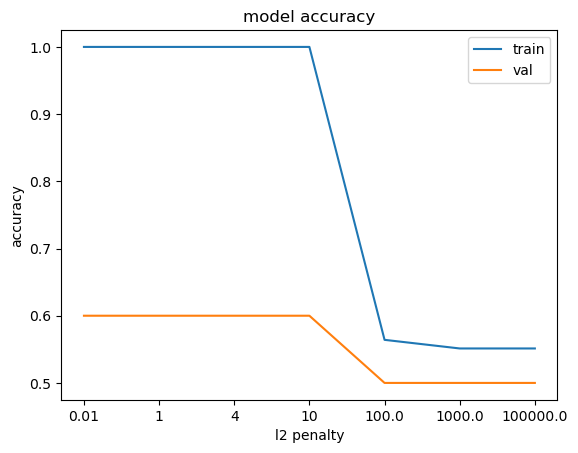

In [32]:
plt.plot(accuracies_table['train_accuracy'])
plt.plot(accuracies_table['validation_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('l2 penalty')
plt.xticks(range(len(l2_penalties)), l2_penalties)
plt.legend(['train', 'val'], loc='upper right')
plt.savefig("model_accuracy.png")
plt.show()


In [33]:
positive_features = coef_table.loc[coef_table['coefficients [L2=4e+00]'].nlargest(5).index, 'features']
negative_features = coef_table.loc[coef_table['coefficients [L2=4e+00]'].nsmallest(5).index, 'features']

In [34]:
print(positive_features)
print(negative_features)

666      666
5101    5101
7065    7065
1261    1261
6261    6261
Name: features, dtype: int64
353      353
3179    3179
7931    7931
5809    5809
6365    6365
Name: features, dtype: int64
